<a href="https://colab.research.google.com/github/manoj-mathivanan/pythonML/blob/main/time%20series%20amazon%20with%20explanation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance==0.2.12 # install the yfinance package

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.50
    Uninstalling yfinance-0.2.50:
      Successfully uninstalled yfinance-0.2.50


In [ ]:
#%%
# Block 1: Import necessary libraries
from IPython import get_ipython # Used for interacting with the IPython kernel
from IPython.display import display # Used for displaying outputs in the notebook
import yfinance as yf # Used for fetching financial data from Yahoo Finance
import pandas as pd # Used for data manipulation and analysis
import numpy as np # Used for numerical operations
import matplotlib.pyplot as plt # Used for creating visualizations
import torch # Used for deep learning with PyTorch
import torch.nn as nn # Used for building neural network models
from copy import deepcopy as dc # Used for creating deep copies of objects
from sklearn.preprocessing import MinMaxScaler # Used for scaling data
from torch.utils.data import Dataset, DataLoader # Used for creating and loading datasets

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.10/dist-packages/yfinance/utils.py:681: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


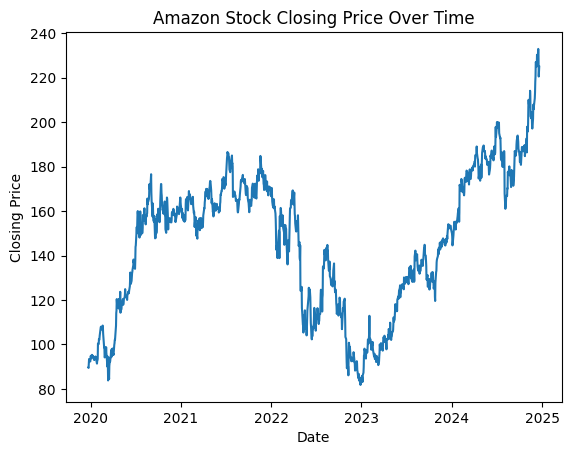

In [ ]:
#%%
# Block 2: Data Collection and Preparation
# Downloading 5 years of daily data for Amazon (AMZN) stock
data_raw = yf.download('AMZN', period='5y', interval='1d')
# Extracting only the 'Close' price into a new DataFrame
data = data_raw[['Close']].copy() # Creating a copy to avoid modifying the original data
# Resetting the index to make 'Date' a column
data.reset_index(inplace=True)
# Renaming the column to 'Date'
data.rename(columns={'index': 'Date'}, inplace=True)
# Setting the device to GPU if available, otherwise CPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# Converting the 'Date' column to pandas datetime type
data['Date'] = pd.to_datetime(data['Date'])
# Plotting the closing price over time
plt.plot(data['Date'], data['Close'])
plt.title('Amazon Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

In [ ]:
#%%
# Block 3: Data Preprocessing for LSTM/RNN
# Function to prepare the DataFrame for LSTM/RNN by creating lagged features
def prepare_dataframe_for_lstm(df, n_steps):
    """
    Prepares the DataFrame for LSTM/RNN by creating lagged features (previous days' closing prices).

    Args:
        df (pd.DataFrame): The input DataFrame containing 'Date' and 'Close' columns.
        n_steps (int): The number of previous days' data to include as features (lookback period).

    Returns:
        pd.DataFrame: The modified DataFrame with lagged features.
    """
    df = dc(df) # Creating a deepcopy of the DataFrame to avoid modifying the original
    df.set_index('Date', inplace=True) # Setting 'Date' as the index
    # Creating lagged features (previous days' closing prices)
    for i in range(1, n_steps + 1):
        df[f'Close(t-{i})'] = df['Close'].shift(i) # Shifting the 'Close' column by i days
    df.dropna(inplace=True) # Dropping rows with missing values (due to shifting)
    return df

# Setting the lookback period (number of previous days to consider)
lookback = 7
# Applying the function to prepare the DataFrame
shifted_df = prepare_dataframe_for_lstm(data, lookback)
# Converting the DataFrame to a NumPy array
shifted_df_as_np = shifted_df.to_numpy()
# Creating a MinMaxScaler object with a range of -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))
# Scaling the data using the scaler
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)
# Separating features (X) and target (y)
X = shifted_df_as_np[:, 1:] # Features are the lagged closing prices
y = shifted_df_as_np[:, 0] # Target is the current closing price
# Flipping the features to make the most recent data first
X = dc(np.flip(X, axis=1))
# Calculating the index to split the data into training and testing sets (95% train, 5% test)
split_index = int(len(X) * 0.95)
# Splitting the data into training and testing sets
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]
# Reshaping the data to be suitable for RNN/LSTM input (samples, timesteps, features)
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))
# Converting the data to PyTorch tensors and setting the data type to float
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()
y_train

tensor([[-0.8421],
        [-0.8237],
        [-0.8210],
        ...,
        [ 0.4301],
        [ 0.4530],
        [ 0.4832]])

In [ ]:
#%%
# Block 4: Dataset and DataLoader
# Defining a custom dataset class for time series data
class TimeSeriesDataset(Dataset):
    """
    A custom dataset class for time series data.

    Args:
        X (torch.Tensor): The input features (lagged closing prices).
        y (torch.Tensor): The target variable (current closing price).
    """
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X) # Returns the number of samples in the dataset

    def __getitem__(self, i):
        return self.X[i], self.y[i] # Returns the ith sample (features and target)

# Creating training and testing datasets using the custom dataset class
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
# Setting the batch size for the data loaders
batch_size = 16
# Creating data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Shuffle training data
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # No need to shuffle test data

Epoch: 1

Val Loss: 0.277
***************************************************

Epoch: 2

Val Loss: 0.466
***************************************************

Epoch: 3

Val Loss: 0.480
***************************************************

Epoch: 4

Val Loss: 0.409
***************************************************

Epoch: 5

Val Loss: 0.244
***************************************************

Epoch: 6

Val Loss: 0.081
***************************************************

Epoch: 7

Val Loss: 0.027
***************************************************

Epoch: 8

Val Loss: 0.025
***************************************************

Epoch: 9

Val Loss: 0.027
***************************************************

Epoch: 10

Val Loss: 0.027
***************************************************

Epoch: 11

Val Loss: 0.027
***************************************************

Epoch: 12

Val Loss: 0.027
***************************************************

Epoch: 13

Val Loss: 0.028
**********************

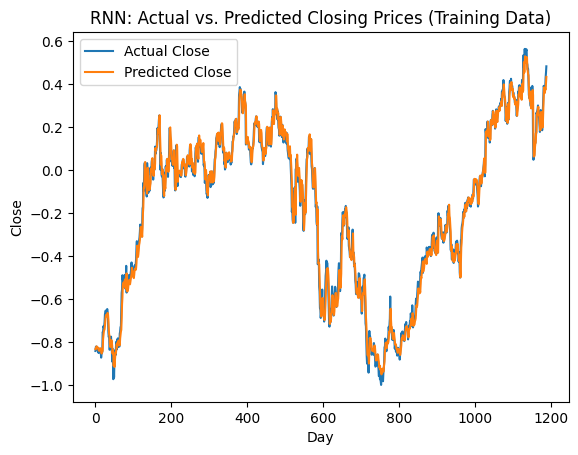

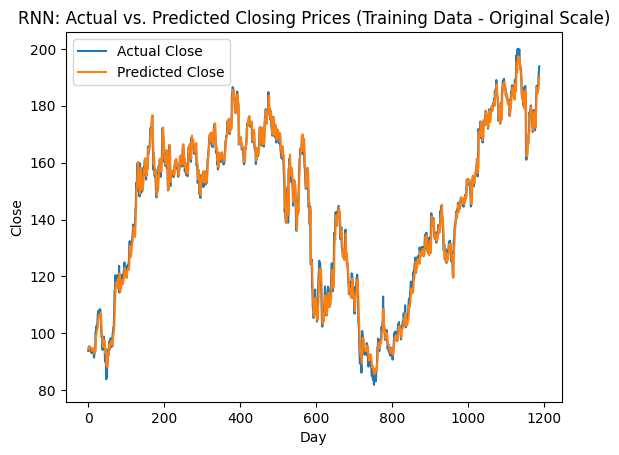

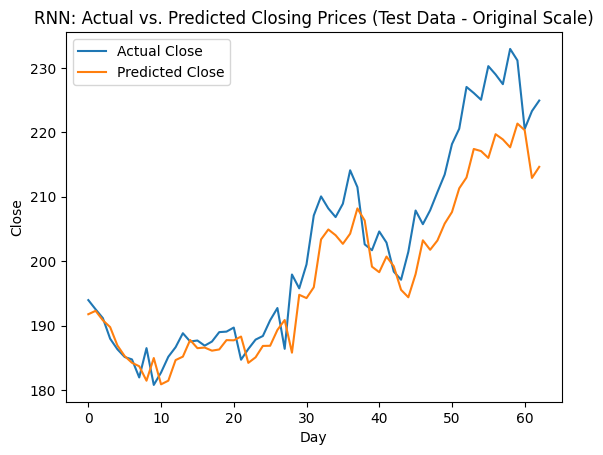

In [ ]:
#%%
# Block 5: RNN Model, Training, and Evaluation
# Defining the RNN model
class RNN(nn.Module):
    """
    A simple RNN model for time series forecasting.

    Args:
        input_size (int): The number of input features (1 in this case, representing the closing price).
        hidden_size (int): The number of hidden units in the RNN layer.
        num_stacked_layers (int): The number of stacked RNN layers.
    """
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        # RNN layer with specified parameters
        self.rnn = nn.RNN(input_size, hidden_size, num_stacked_layers, batch_first=True)
        # Fully connected layer for output
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        # Initial hidden state (all zeros)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        # Passing the input through the RNN layer
        out, _ = self.rnn(x, h0)
        # Taking the output from the last time step and passing it through the fully connected layer
        out = self.fc(out[:, -1, :])
        return out

# Creating an instance of the RNN model
model_rnn = RNN(1, 4, 1) # Input size = 1, hidden size = 4, num_stacked_layers = 1
# Moving the model to the device (GPU or CPU)
model_rnn.to(device)

# Defining the training function for one epoch
def train_one_epoch():
    """
    Trains the RNN model for one epoch.
    """
    model_rnn.train(True) # Setting the model to training mode
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0 # Initializing the running loss

    # Iterating through the training data loader
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device) # Moving data to the device

        # Forward pass
        output = model_rnn(x_batch) # Getting the model's predictions
        # Calculating the loss using the loss function
        loss = loss_function(output, y_batch)
        running_loss += loss.item() # Accumulating the loss

        # Backward pass and optimization
        optimizer.zero_grad() # Resetting the gradients
        loss.backward() # Calculating the gradients
        optimizer.step() # Updating the model's parameters

        # Printing the average loss every 100 batches
        if batch_index % 100 == 99:
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index + 1, avg_loss_across_batches))
            running_loss = 0.0 # Resetting the running loss
    print() # Printing a newline for better readability

# Defining the validation function for one epoch
def validate_one_epoch():
    """
    Validates the RNN model on the test data.
    """
    model_rnn.train(False) # Setting the model to evaluation mode
    running_loss = 0.0 # Initializing the running loss

    # Iterating through the test data loader
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device) # Moving data to the device

        # Forward pass (without calculating gradients)
        with torch.no_grad():
            output = model_rnn(x_batch) # Getting the model's predictions
            # Calculating the loss using the loss function
            loss = loss_function(output, y_batch)
            running_loss += loss.item() # Accumulating the loss

    # Calculating and printing the average validation loss
    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print() # Printing a newline for better readability

# Setting hyperparameters for training
learning_rate = 0.001 # Learning rate for the optimizer
num_epochs = 50 # Number of training epochs
# Defining the loss function (Mean Squared Error)
loss_function = nn.MSELoss()
# Defining the optimizer (Adam optimizer)
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=learning_rate)

# Training the model for the specified number of epochs
for epoch in range(num_epochs):
    train_one_epoch() # Training for one epoch
    validate_one_epoch() # Validating on the test data

# Making predictions on the training data (without calculating gradients)
with torch.no_grad():
    predicted_rnn = model_rnn(X_train.to(device)).to('cpu').numpy()

# Plotting the actual and predicted closing prices for the training data
plt.plot(y_train, label='Actual Close')
plt.plot(predicted_rnn, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('RNN: Actual vs. Predicted Closing Prices (Training Data)')
plt.legend()
plt.show()

# Flattening the predictions and inverting the scaling to get the original scale
train_predictions_rnn = predicted_rnn.flatten()

dummies = np.zeros((X_train.shape[0], lookback + 1))
dummies[:, 0] = train_predictions_rnn
dummies = scaler.inverse_transform(dummies) # Inverting the scaling

train_predictions_rnn = dc(dummies[:, 0])

# Inverting the scaling for the actual training data to get the original scale
dummies = np.zeros((X_train.shape[0], lookback + 1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies) # Inverting the scaling

new_y_train_rnn = dc(dummies[:, 0])

# Plotting the actual and predicted closing prices for the training data (original scale)
plt.plot(new_y_train_rnn, label='Actual Close')
plt.plot(train_predictions_rnn, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('RNN: Actual vs. Predicted Closing Prices (Training Data - Original Scale)')
plt.legend()
plt.show()

# Making predictions on the test data
test_predictions_rnn = model_rnn(X_test.to(device)).detach().cpu().numpy().flatten()

# Inverting the scaling for the test predictions to get the original scale
dummies = np.zeros((X_test.shape[0], lookback + 1))
dummies[:, 0] = test_predictions_rnn
dummies = scaler.inverse_transform(dummies) # Inverting the scaling

test_predictions_rnn = dc(dummies[:, 0])

# Inverting the scaling for the actual test data to get the original scale
dummies = np.zeros((X_test.shape[0], lookback + 1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies) # Inverting the scaling

new_y_test_rnn = dc(dummies[:, 0])

# Plotting the actual and predicted closing prices for the test data (original scale)
plt.plot(new_y_test_rnn, label='Actual Close')
plt.plot(test_predictions_rnn, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('RNN: Actual vs. Predicted Closing Prices (Test Data - Original Scale)')
plt.legend()
plt.show()

Epoch: 1

Val Loss: 0.604
***************************************************

Epoch: 2

Val Loss: 0.181
***************************************************

Epoch: 3

Val Loss: 0.085
***************************************************

Epoch: 4

Val Loss: 0.079
***************************************************

Epoch: 5

Val Loss: 0.086
***************************************************

Epoch: 6

Val Loss: 0.086
***************************************************

Epoch: 7

Val Loss: 0.087
***************************************************

Epoch: 8

Val Loss: 0.084
***************************************************

Epoch: 9

Val Loss: 0.080
***************************************************

Epoch: 10

Val Loss: 0.071
***************************************************

Epoch: 11

Val Loss: 0.074
***************************************************

Epoch: 12

Val Loss: 0.063
***************************************************

Epoch: 13

Val Loss: 0.064
**********************

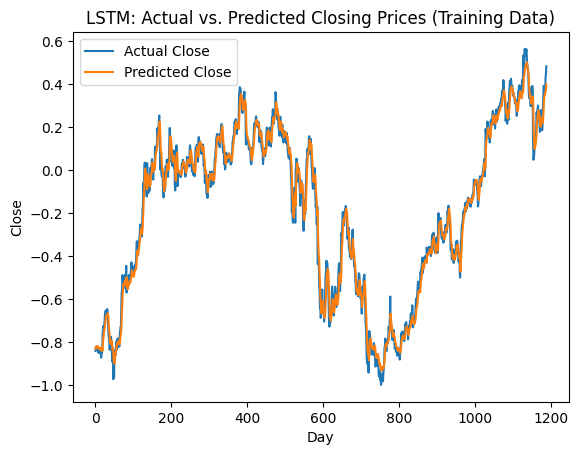

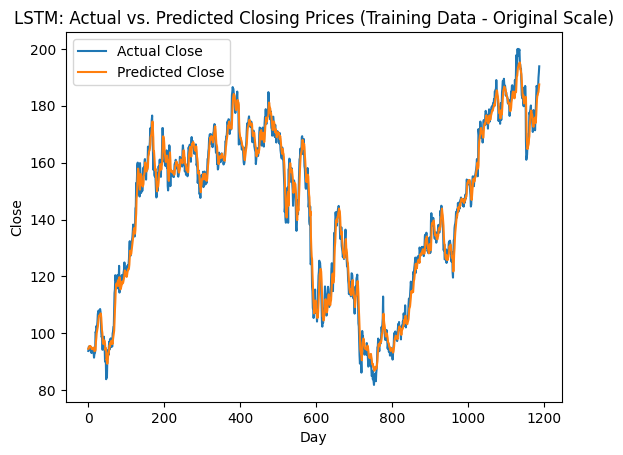

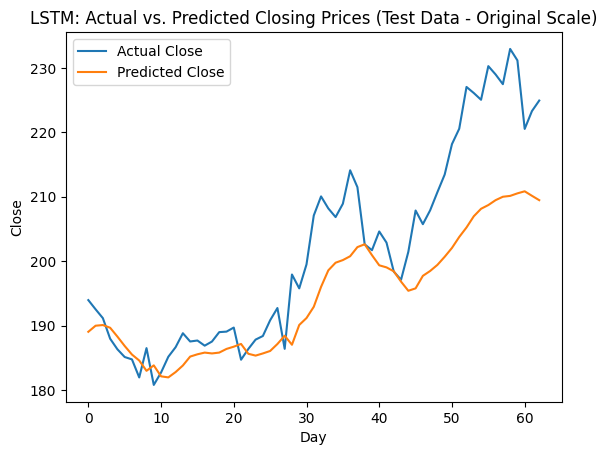

In [ ]:
#%%
# Block 6: LSTM Model, Training, and Evaluation
# Defining the LSTM model
class LSTM(nn.Module):
    """
    An LSTM model for time series forecasting.

    Args:
        input_size (int): The number of input features (1 in this case, representing the closing price).
        hidden_size (int): The number of hidden units in the LSTM layer.
        num_stacked_layers (int): The number of stacked LSTM layers.
    """
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        # LSTM layer with specified parameters
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        # Fully connected layer for output
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        # Initial hidden and cell states (all zeros)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        # Passing the input through the LSTM layer
        out, _ = self.lstm(x, (h0, c0))
        # Taking the output from the last time step and passing it through the fully connected layer
        out = self.fc(out[:, -1, :])
        return out

# Creating an instance of the LSTM model
model = LSTM(1, 4, 1) # Input size = 1, hidden size = 4, num_stacked_layers = 1
# Moving the model to the device (GPU or CPU)
model.to(device)

# Defining the training function for one epoch (same as for RNN)
def train_one_epoch():
    """
    Trains the LSTM model for one epoch.
    """
    model.train(True) # Setting the model to training mode
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0 # Initializing the running loss

    # Iterating through the training data loader
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device) # Moving data to the device

        # Forward pass
        output = model(x_batch) # Getting the model's predictions
        # Calculating the loss using the loss function
        loss = loss_function(output, y_batch)
        running_loss += loss.item() # Accumulating the loss

        # Backward pass and optimization
        optimizer.zero_grad() # Resetting the gradients
        loss.backward() # Calculating the gradients
        optimizer.step() # Updating the model's parameters

        # Printing the average loss every 100 batches
        if batch_index % 100 == 99:
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index + 1, avg_loss_across_batches))
            running_loss = 0.0 # Resetting the running loss
    print() # Printing a newline for better readability

# Defining the validation function for one epoch (same as for RNN)
def validate_one_epoch():
    """
    Validates the LSTM model on the test data.
    """
    model.train(False) # Setting the model to evaluation mode
    running_loss = 0.0 # Initializing the running loss

    # Iterating through the test data loader
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device) # Moving data to the device

        # Forward pass (without calculating gradients)
        with torch.no_grad():
            output = model(x_batch) # Getting the model's predictions
            # Calculating the loss using the loss function
            loss = loss_function(output, y_batch)
            running_loss += loss.item() # Accumulating the loss

    # Calculating and printing the average validation loss
    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print() # Printing a newline for better readability

# Setting hyperparameters for training
learning_rate = 0.001 # Learning rate for the optimizer
num_epochs = 30 # Number of training epochs
# Defining the loss function (Mean Squared Error)
loss_function = nn.MSELoss()
# Defining the optimizer (Adam optimizer)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training the model for the specified number of epochs
for epoch in range(num_epochs):
    train_one_epoch() # Training for one epoch
    validate_one_epoch() # Validating on the test data

# Making predictions on the training data (without calculating gradients)
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

# Plotting the actual and predicted closing prices for the training data
plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('LSTM: Actual vs. Predicted Closing Prices (Training Data)')
plt.legend()
plt.show()

# Flattening the predictions and inverting the scaling to get the original scale
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback + 1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies) # Inverting the scaling

train_predictions = dc(dummies[:, 0])

# Inverting the scaling for the actual training data to get the original scale
dummies = np.zeros((X_train.shape[0], lookback + 1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies) # Inverting the scaling

new_y_train = dc(dummies[:, 0])

# Plotting the actual and predicted closing prices for the training data (original scale)
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('LSTM: Actual vs. Predicted Closing Prices (Training Data - Original Scale)')
plt.legend()
plt.show()

# Making predictions on the test data
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

# Inverting the scaling for the test predictions to get the original scale
dummies = np.zeros((X_test.shape[0], lookback + 1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies) # Inverting the scaling

test_predictions = dc(dummies[:, 0])

# Inverting the scaling for the actual test data to get the original scale
dummies = np.zeros((X_test.shape[0], lookback + 1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies) # Inverting the scaling

new_y_test = dc(dummies[:, 0])

# Plotting the actual and predicted closing prices for the test data (original scale)
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('LSTM: Actual vs. Predicted Closing Prices (Test Data - Original Scale)')
plt.legend()
plt.show()